In [29]:
pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 533.5/533.5 kB 3.4 MB/s eta 0:00:00


In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import shap

In [23]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

Первичный анализ данных
Тренировочные данные:
Количество записей: 5734
Количество признаков: 162

Поля: Уникальные идентификаторы полей
Год: Год сбора данных

Кластер: Идентификатор кластера, к которому принадлежит поле

Площадь: Площадь поля

Урожайность: Урожайность поля

Геозона: Идентификатор геозоны, к которой принадлежит поле

Предшественник: Предшествующая культура

FAO: Код FAO для культуры

N_kg/ga, P_kg/ga, K_kg/ga: Количество удобрений, использованных на гектар

NDVI: Индексы NDVI для различных недель

In [ ]:
# Вывод первых нескольких строк тренировочного и тестового наборов данных для предварительного просмотра
train_head = train_data.head()
test_head = test_data.head()

# Получение общей информации о тренировочном и тестовом наборах данных
train_info = train_data.info()
test_info = test_data.info()

train_info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5734 entries, 0 to 5733
Columns: 162 entries, Field to 39_week_ndvi
dtypes: float64(157), int64(5)
memory usage: 7.1 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2192 entries, 0 to 2191
Columns: 162 entries, Field to 39_week_ndvi
dtypes: float64(156), int64(6)
memory usage: 2.7 MB


Тренировочные данные:
FAO: 790 пропущенных значений
K_kg/ga (Калий): 335 пропущенных значений
P_kg/ga (Фосфор): 227 пропущенных значений
Тестовые данные:
FAO: 501 пропущенное значение
K_kg/ga (Калий): 231 пропущенное значение
P_kg/ga (Фосфор): 229 пропущенных значений
Дальнейшие шаги по очистке данных:

In [ ]:
# Определение пропущенных значений в тренировочном и тестовом наборах данных
missing_train = train_data.isnull().sum().sort_values(ascending=False)
missing_test = test_data.isnull().sum().sort_values(ascending=False)

# Выбираем только те колонки, где есть пропущенные значения
missing_train = missing_train[missing_train > 0]
missing_test = missing_test[missing_test > 0]

(missing_train, missing_test)

(FAO        790
 K_kg/ga    335
 P_kg/ga    227
 dtype: int64,
 FAO        501
 K_kg/ga    231
 P_kg/ga    229
 dtype: int64)

Анализ распределения признаков с пропущенными значениями
1. Распределение FAO (Тренировочные данные):
Распределение кажется дискретным и категориальным. Заполнение средним значением здесь не подойдет, так как это может создать несуществующие категории. Вместо этого можно использовать моду (наиболее частое значение) или удалить строки с пропущенными значениями.
2. Распределение K_kg/ga (Калий):
Распределение кажется скошенным вправо с некоторыми потенциальными выбросами. В таком случае медиана будет более уместна, чем среднее значение, так как она менее чувствительна к экстремальным значениям.
3. Распределение P_kg/ga (Фосфор):
Распределение также скошено вправо и может содержать выбросы. Похоже, что и здесь использование медианы будет предпочтительнее среднего значения.

Итог:


FAO: Заполнить пропущенные значения модой (наиболее часто встречающимся значением).
K_kg/ga и P_kg/ga: Заполнить пропущенные значения медианой.

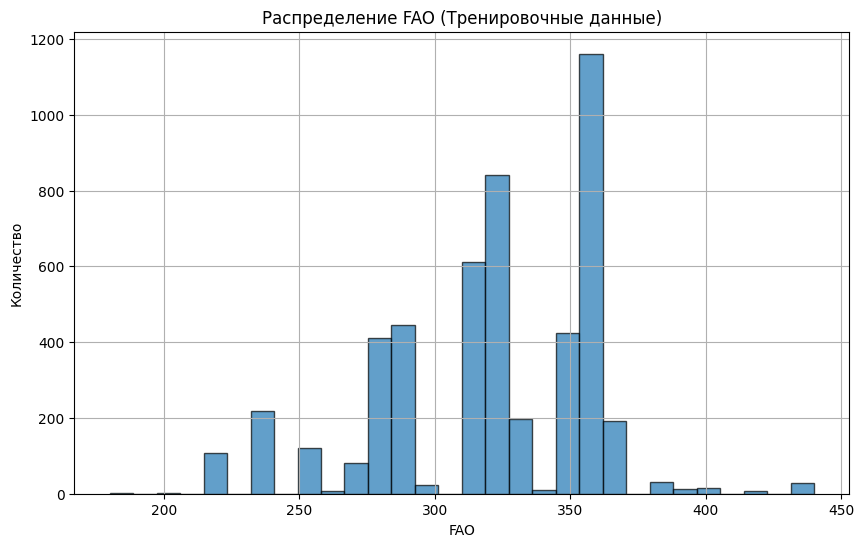

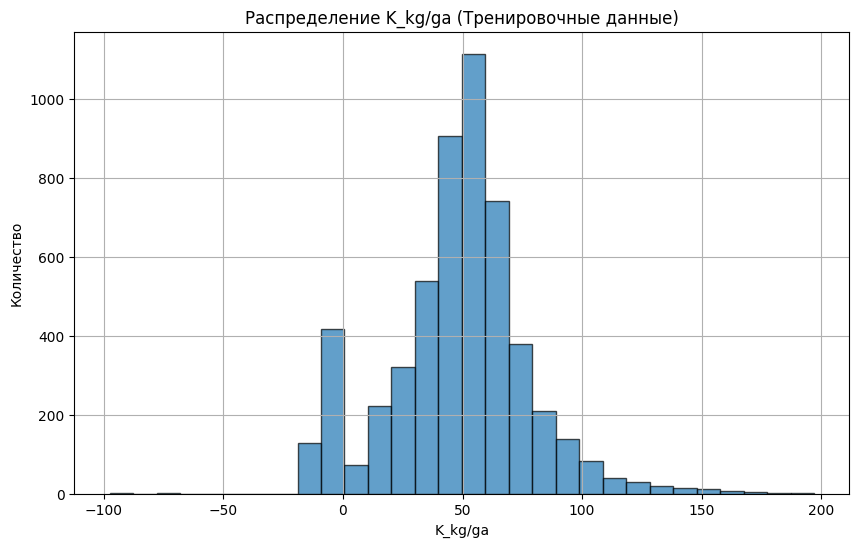

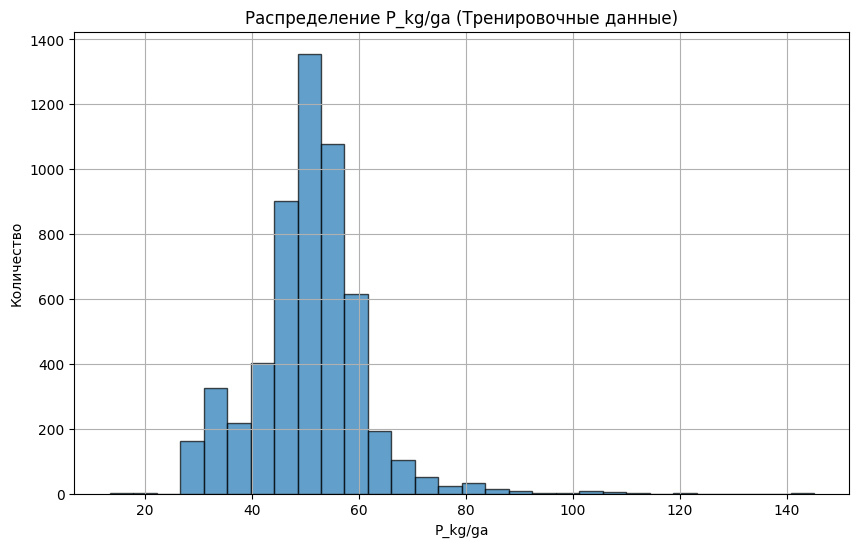

In [ ]:
import matplotlib.pyplot as plt

# Определение функции для визуализации распределения признаков
def plot_distribution(data, feature, title):
    plt.figure(figsize=(10, 6))
    plt.hist(data[feature].dropna(), bins=30, edgecolor='k', alpha=0.7)
    plt.title(title)
    plt.xlabel(feature)
    plt.ylabel('Количество')
    plt.grid(True)
    plt.show()

# Визуализация распределения для признаков с пропущенными значениями
plot_distribution(train_data, 'FAO', 'Распределение FAO (Тренировочные данные)')
plot_distribution(train_data, 'K_kg/ga', 'Распределение K_kg/ga (Тренировочные данные)')
plot_distribution(train_data, 'P_kg/ga', 'Распределение P_kg/ga (Тренировочные данные)')


In [ ]:
# Обработка пропущенных значений

# Заполнение пропущенных значений для FAO модой
mode_FAO = train_data['FAO'].mode()[0]
train_data['FAO'].fillna(mode_FAO, inplace=True)
test_data['FAO'].fillna(mode_FAO, inplace=True)

# Заполнение пропущенных значений для K_kg/ga и P_kg/ga медианой
median_K = train_data['K_kg/ga'].median()
median_P = train_data['P_kg/ga'].median()

train_data['K_kg/ga'].fillna(median_K, inplace=True)
train_data['P_kg/ga'].fillna(median_P, inplace=True)

test_data['K_kg/ga'].fillna(median_K, inplace=True)
test_data['P_kg/ga'].fillna(median_P, inplace=True)

# Проверка, что больше нет пропущенных значений
missing_values_train = train_data.isnull().sum().max()
missing_values_test = test_data.isnull().sum().max()

(missing_values_train, missing_values_test)


(0, 0)

1. Boxplot для FAO (Тренировочные данные):
Нет явных выбросов. FAO кажется категориальным признаком, так что его распределение не подразумевает наличие выбросов.
2. Boxplot для K_kg/ga (Тренировочные данные):
Наблюдаются потенциальные выбросы в верхней части распределения. Это могут быть реальные значения, представляющие поля с очень высоким использованием калийных удобрений, или ошибки в данных.
3. Boxplot для P_kg/ga (Тренировочные данные):
Также присутствуют потенциальные выбросы. Как и в случае с калием, это может быть как естественное варьирование, так и ошибки.

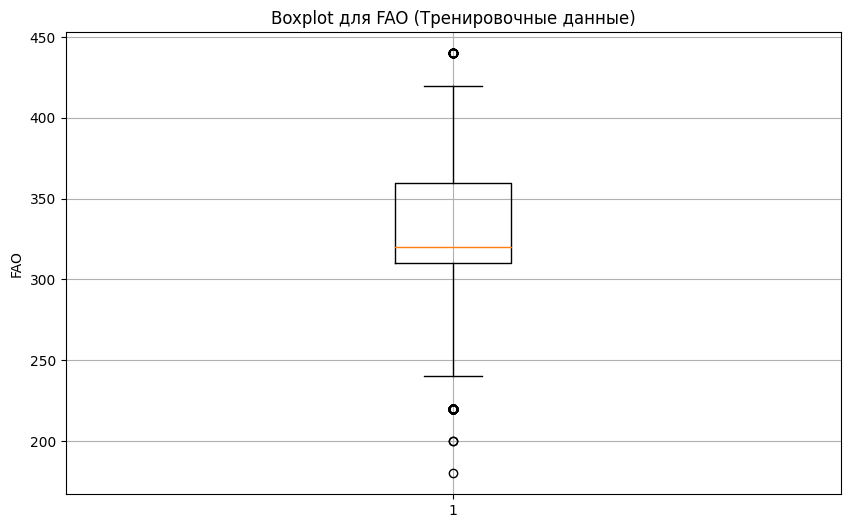

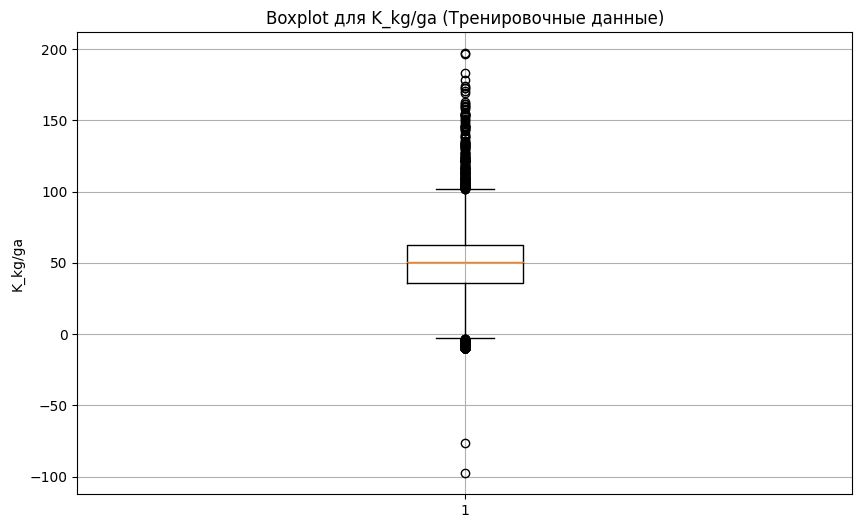

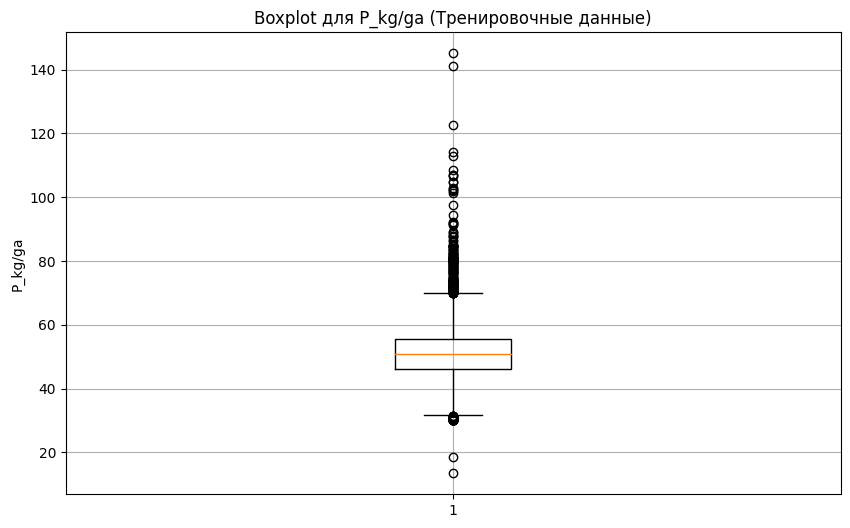

In [ ]:
# Определение функции для визуализации выбросов с помощью boxplot
def plot_boxplot(data, feature, title):
    plt.figure(figsize=(10, 6))
    plt.boxplot(data[feature].dropna())
    plt.title(title)
    plt.ylabel(feature)
    plt.grid(True)
    plt.show()

# Визуализация выбросов для признаков, где были пропущенные значения (так как они могут быть более подвержены аномалиям)
plot_boxplot(train_data, 'FAO', 'Boxplot для FAO (Тренировочные данные)')
plot_boxplot(train_data, 'K_kg/ga', 'Boxplot для K_kg/ga (Тренировочные данные)')
plot_boxplot(train_data, 'P_kg/ga', 'Boxplot для P_kg/ga (Тренировочные данные)')



Анализ связи выбросов с целевой переменной (урожайностью)
1. Взаимосвязь между K_kg/ga и урожайностью:
Некоторые высокие значения K_kg/ga соответствуют различным уровням урожайности, что указывает на то, что они могут быть реальными данными. Однако есть некоторые экстремальные значения K_kg/ga с относительно низкой урожайностью, что может указывать на потенциальные аномалии.
2. Взаимосвязь между P_kg/ga и урожайностью:
Подобно K_kg/ga, высокие значения P_kg/ga соответствуют различным уровням урожайности. Опять же, некоторые экстремальные значения P_kg/ga с низкой урожайностью могут быть аномальными.
Выводы и дальнейшие шаги:
Выбросы могут быть реальными данными: Учитывая, что некоторые высокие значения удобрений соответствуют высокой урожайности, они могут быть реальными и важными для модели.
Некоторые выбросы могут быть аномальными: Экстремальные значения удобрений с низкой урожайностью могут быть ошибками или аномальными данными.

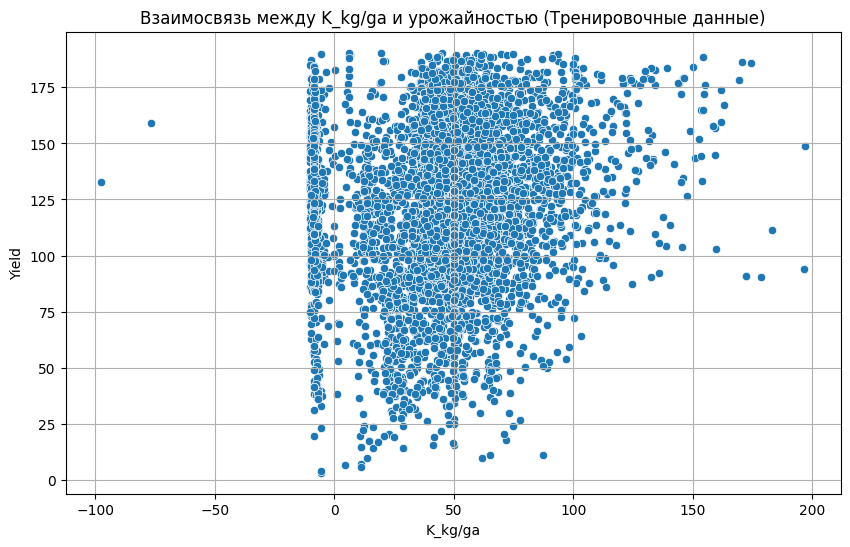

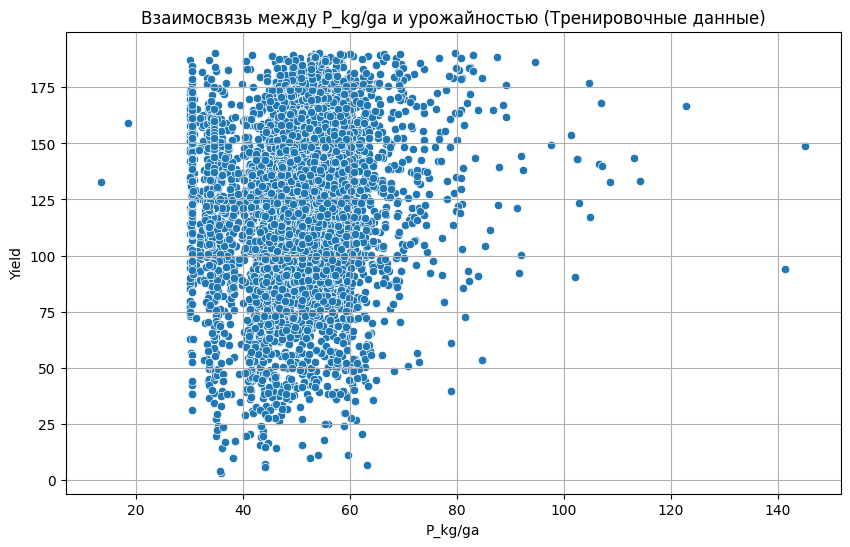

In [ ]:
import seaborn as sns

# Определение функции для анализа связи выбросов с целевой переменной
def plot_scatter(data, x, y, title):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=x, y=y, data=data)
    plt.title(title)
    plt.grid(True)
    plt.show()

# Визуализация связи выбросов удобрений с урожайностью
plot_scatter(train_data, 'K_kg/ga', 'Yield', 'Взаимосвязь между K_kg/ga и урожайностью (Тренировочные данные)')
plot_scatter(train_data, 'P_kg/ga', 'Yield', 'Взаимосвязь между P_kg/ga и урожайностью (Тренировочные данные)')


In [ ]:
def calculate_iqr_thresholds(data, feature):
    Q1 = data[feature].quantile(0.25)
    Q3 = data[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound, upper_bound

# Рассчитаем IQR и пороги для K_kg/ga и P_kg/ga
k_lower_bound, k_upper_bound = calculate_iqr_thresholds(train_data, 'K_kg/ga')
p_lower_bound, p_upper_bound = calculate_iqr_thresholds(train_data, 'P_kg/ga')

(k_upper_bound, p_upper_bound)


(101.76119490449081, 69.92103380527115)

Прежде чем принимать решение об удалении или корректировке выбросов, важно определить порог, выше которого значения будут считаться аномальными. Один из способов — использовать межквартильный размах (IQR). Для каждого признака с выбросами (K_kg/ga и P_kg/ga) можно рассчитать IQR и установить верхний порог, например, как 1.5*IQR выше третьего квартиля. Значения выше этого порога могут быть выбросами и обработаны.


Рассчитываем IQR и определяем верхние пороги для K_kg/ga и P_kg/ga

Итог:

K_kg/ga (Калий): Значения выше 101.76 кг/га могут считаться выбросами.
P_kg/ga (Фосфор): Значения выше 69.92 кг/га могут считаться выбросами.

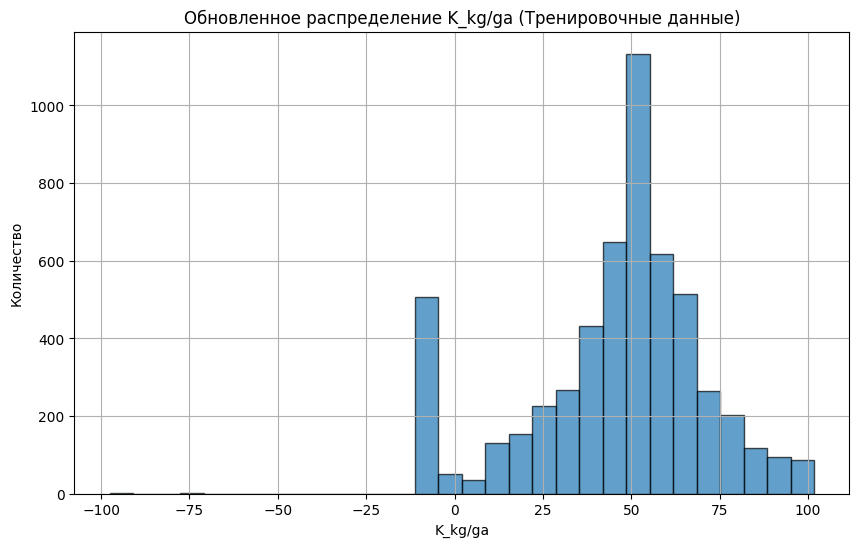

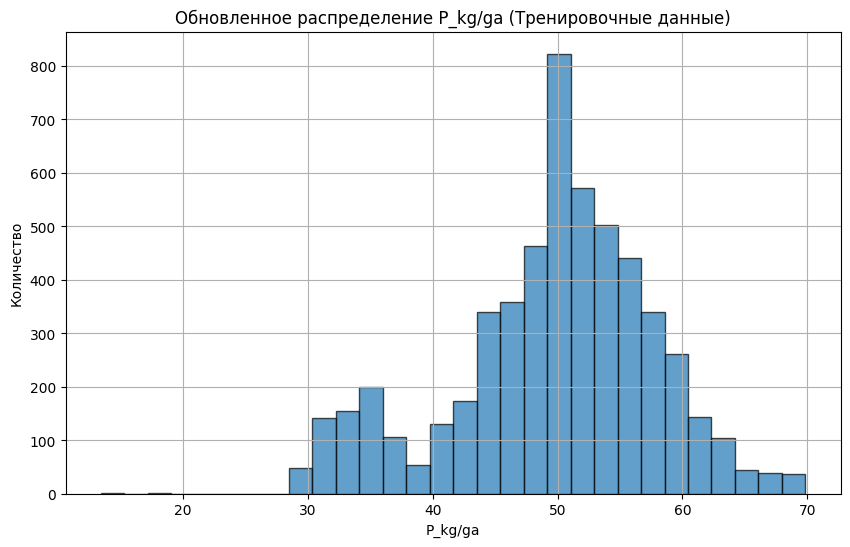

257

In [ ]:
# Удаление выбросов из тренировочного набора данных
train_data_clean = train_data[(train_data['K_kg/ga'] <= k_upper_bound) & (train_data['P_kg/ga'] <= p_upper_bound)]

# Построение распределения на обновленных данных
def plot_updated_distribution(data, feature, title):
    plt.figure(figsize=(10, 6))
    plt.hist(data[feature], bins=30, edgecolor='k', alpha=0.7)
    plt.title(title)
    plt.xlabel(feature)
    plt.ylabel('Количество')
    plt.grid(True)
    plt.show()

# Визуализация обновленных распределений для K_kg/ga и P_kg/ga
plot_updated_distribution(train_data_clean, 'K_kg/ga', 'Обновленное распределение K_kg/ga (Тренировочные данные)')
plot_updated_distribution(train_data_clean, 'P_kg/ga', 'Обновленное распределение P_kg/ga (Тренировочные данные)')

# Возвращаем количество удаленных строк
rows_removed = train_data.shape[0] - train_data_clean.shape[0]
rows_removed


Обновленные распределения:
K_kg/ga (Калий): Распределение теперь выглядит менее скошенным, и экстремальные значения были удалены.

P_kg/ga (Фосфор): Также наблюдается уменьшение скошенности распределения, и выбросы были устранены.

Создадим некоторые взаимодействия признаков и статистические агрегации для NDVI.


K_P_ratio: Отношение количества калия к фосфору. Этот признак может помочь выявить оптимальное соотношение удобрений для максимальной урожайности.
NDVI_mean: Среднее значение NDVI за все недели. Этот признак предоставляет общую информацию о состоянии вегетации на протяжении всего сезона.
log_K_kg/ga и log_P_kg/ga: Логарифмически преобразованные значения удобрений.

In [ ]:
import numpy as np

# Создание взаимодействующих признаков: отношение удобрений
train_data_clean['K_P_ratio'] = train_data_clean['K_kg/ga'] / (train_data_clean['P_kg/ga'] + 1)  # Добавляем 1 для избежания деления на ноль

# Статистические агрегации для NDVI: среднее значение NDVI за все недели
ndvi_columns = [col for col in train_data_clean.columns if 'ndvi' in col]
train_data_clean['NDVI_mean'] = train_data_clean[ndvi_columns].mean(axis=1)

# Логарифмическое преобразование удобрений для уменьшения скошенности
train_data_clean['log_K_kg/ga'] = np.log(train_data_clean['K_kg/ga'] + 1)
train_data_clean['log_P_kg/ga'] = np.log(train_data_clean['P_kg/ga'] + 1)

# Проверка наличия новых признаков
new_features_preview = train_data_clean[['K_P_ratio', 'NDVI_mean', 'log_K_kg/ga', 'log_P_kg/ga']].head()
new_features_preview


<ipython-input-11-27fb34010182>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data_clean['K_P_ratio'] = train_data_clean['K_kg/ga'] / (train_data_clean['P_kg/ga'] + 1)  # Добавляем 1 для избежания деления на ноль
<ipython-input-11-27fb34010182>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data_clean['NDVI_mean'] = train_data_clean[ndvi_columns].mean(axis=1)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = get

,K_P_ratio,NDVI_mean,log_K_kg/ga,log_P_kg/ga
0,0.962221,0.613468,3.955615,3.974794
1,0.542766,0.636506,3.016795,3.577674
2,1.210208,0.573880,4.417209,4.214275
3,0.734050,0.629990,3.648107,3.930900
4,0.927731,0.614882,3.913875,3.968724


Построим модели разного типа на основе наших данных

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Подготовка данных для моделирования
X = train_data_clean.drop('Yield', axis=1)  # Удаляем целевую переменную
y = train_data_clean['Yield']  # Целевая переменная

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Обучение и оценка моделей
models = {
    "Линейная регрессия": LinearRegression(),
    "Случайный лес": RandomForestRegressor(random_state=42),
    "Градиентный бустинг": GradientBoostingRegressor(random_state=42)
}



In [34]:
# Замена NaN на медианные значения
X_train.fillna(X_train.median(), inplace=True)

# Замена бесконечностей на максимальные допустимые значения в каждом столбце
X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
X_train.fillna(X_train.max(), inplace=True)


In [ ]:
X_test.fillna(X_train.median(), inplace=True)
X_test.replace([np.inf, -np.inf], np.nan, inplace=True)
X_test.fillna(X_train.max(), inplace=True)

# Повторное обучение и оценка моделей
results_updated = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mae = mean_absolute_error(y_test, y_pred)
    results_updated[name] = {'RMSE': rmse, 'MAE': mae}

results_updated


{'Линейная регрессия': {'RMSE': 16.103071593168433, 'MAE': 12.432360304734127},
 'Случайный лес': {'RMSE': 15.025589183788583, 'MAE': 11.242226258853453},
 'Градиентный бустинг': {'RMSE': 15.983760772880952,
  'MAE': 12.242872316492827}}

Построим модель LGBM

In [ ]:
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

lgbm_model = LGBMRegressor(random_state=42)
lgbm_model.fit(X_train, y_train)

# Оценка модели LightGBM на тестовых данных
y_pred_lgbm = lgbm_model.predict(X_train)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)

print(f"RMSE: {rmse}, MAE: {mae}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010059 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22658
[LightGBM] [Info] Number of data points in the train set: 4381, number of used features: 165
[LightGBM] [Info] Start training from score 120.517608
RMSE: 15.983760772880952, MAE: 12.242872316492827


Сделаем подбор гиперпараметров для увеличения точности модели

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
# Создание и обучение модели LightGBM на уменьшенных данных
lgbm_model = LGBMRegressor(random_state=42)

# Параметры для настройки
param_grid = {
    'num_leaves': [20,25, 30, 31, 50, 60, 70, 100],  # Количество листьев в одном дереве
    'learning_rate': [0.01, 0.1,0.2, 0.3],  # Скорость обучения
    'n_estimators': [50, 100, 200, 400, 500],  # Количество деревьев в ансамбле
}

# Настройка гиперпараметров с помощью случайного поиска
random_search = RandomizedSearchCV(lgbm_model, param_grid, n_iter=20, scoring='neg_mean_squared_error', n_jobs=-1, cv=3, random_state=42)
random_search.fit(X_train, y_train)

# Лучшая модель после настройки
best_lgbm = random_search.best_estimator_

# Оценка лучшей модели LightGBM на тестовых данных
y_pred_lgbm = best_lgbm.predict(X_test)
rmse = mean_squared_error(y_test, y_pred_lgbm, squared=False)
mae = mean_absolute_error(y_test, y_pred_lgbm)

print(f"Лучшие параметры: {random_search.best_params_}")
print(f"RMSE: {rmse}, MAE: {mae}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015976 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22658
[LightGBM] [Info] Number of data points in the train set: 4381, number of used features: 165
[LightGBM] [Info] Start training from score 120.517608
Лучшие параметры: {'num_leaves': 30, 'n_estimators': 400, 'learning_rate': 0.1}
RMSE: 14.340160948871288, MAE: 10.767484832273638


In [26]:
test_data['K_P_ratio'] = test_data['K_kg/ga'] / (test_data['P_kg/ga'] + 1)
test_data['NDVI_mean'] = test_data[ndvi_columns].mean(axis=1)
test_data['log_K_kg/ga'] = np.log(test_data['K_kg/ga'] + 1)
test_data['log_P_kg/ga'] = np.log(test_data['P_kg/ga'] + 1)

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Протестируем модель на тестовых данных и просчитаем средневзвешенное значение по кластерам

In [27]:
X_test = test_data.drop(['Yield'], axis=1)
y_pred_lgbm = best_lgbm.predict(X_test)

In [28]:
weighted_averages = {}
for cluster in test_data['Cluster'].unique():
    cluster_data = test_data[test_data['Cluster'] == cluster]
    cluster_pred = y_pred_lgbm[cluster_data.index]
    weighted_average = (cluster_data['Area'] * cluster_pred).sum() / cluster_data['Area'].sum()
    weighted_averages[cluster] = weighted_average

# Вывести средневзвешенные прогнозы урожайности
print(weighted_averages)

{1: 131.5805145193202, 3: 72.34058452960224, 4: 88.35177219692389, 0: 130.2616498045326, 5: 62.724896381571384, 2: 109.2828028277738, 6: 78.84948272965306}


На этом графике можно увидеть, что наибольшее влияние на модель оказывает среднее значение NDVI (NDVI_mean), а также значения NDVI за определенные недели (например, 33_week_ndvi, 39_week_ndvi и т.д.). Это указывает на то, что индексы вегетации, и в частности их среднее значение, являются значимыми предикторами урожайности в модели.

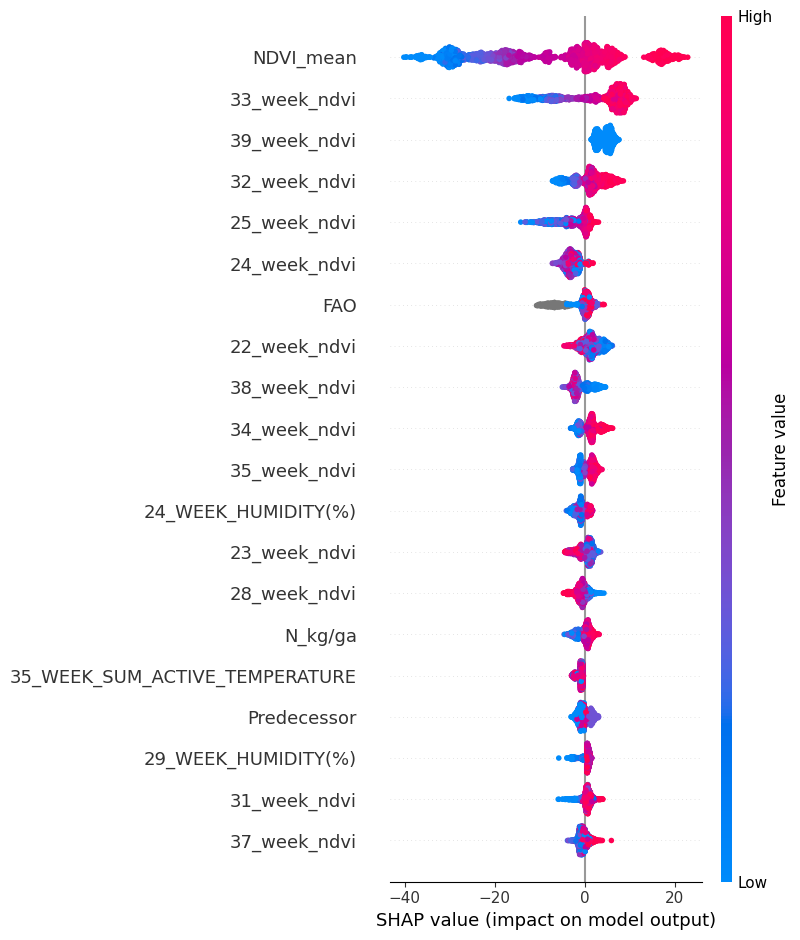

                               feature  importance
162                          NDVI_mean   13.993968
154                       33_week_ndvi    7.345942
160                       39_week_ndvi    4.420412
153                       32_week_ndvi    2.959091
146                       25_week_ndvi    2.936595
..                                 ...         ...
127     24_WEEK_SUM_ACTIVE_TEMPERATURE    0.008877
131     28_WEEK_SUM_ACTIVE_TEMPERATURE    0.007586
28   8_YEARLY_sum_CALCULATED_RADIATION    0.006788
1                                 Year    0.000000
164                        log_P_kg/ga    0.000000

[165 rows x 2 columns]


In [33]:
explainer = shap.TreeExplainer(best_lgbm)
shap_values = explainer.shap_values(X_test)

# Визуализация важности признаков
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns)

# Вывод важности признаков в виде DataFrame
feature_importance = pd.DataFrame({
    'feature': X_test.columns,
    'importance': np.abs(shap_values).mean(axis=0)
}).sort_values(by='importance', ascending=False)

print(feature_importance)